<a href="https://colab.research.google.com/github/oscarnavmac/Proyecto-Final-de-Redes-Convolucionales/blob/main/Copia_de_Proyecto_Final_Oscar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation of Convolutional Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [3]:
# Preprocesamiento de datos para CIFAR-10.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201]),
])

# Cargando los datos
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

100%|██████████| 170498071/170498071 [00:03<00:00, 43692051.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
validation_split = 0.1

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

In [5]:
# Dataloaders: usaremos un tamaño de lote de 128
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Model and utility functions

In [25]:
class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    num_classes: An integer indicating number of output units.
  """
  def __init__(self, num_classes):
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(16, 16, kernel_size=3),
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=16 * 5 * 5,
                    out_features=num_classes)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [7]:
# Class for the teacher model
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
# Class for the teacher model
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
teacher.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt
100%|██████████| 58.3M/58.3M [00:00<00:00, 68.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
def validate(model, valid_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    model.train()

    return accuracy

In [22]:
def train(model, train_loader, valid_loader, epochs, learning_rate, device, momentum=0.9, weight_decay=0.0005):
    train_losses = []
    valid_accs = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: Una coleccion de imagenes con batch_size tamano de lote
            # labels: Un vector de dimensionalidad batch_size con enteros denotando la clase para cada imagen
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        valid_accuracy = validate(model, valid_loader, criterion, device)
        valid_accs.append(valid_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Valid Accuracy: {valid_accuracy:.2f}%")
        scheduler.step()

    return train_losses, valid_accs

In [106]:
def test (model, test_loader, device, verbose=True):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels, = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if verbose:
        print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [121]:
import numpy as np
from time import perf_counter

def latency(model, loader, device):
    latencies = []
    for _ in range(10):
        test(model, loader, device, verbose=False) #warm up
    for _ in range(10):
        start_time = perf_counter()
        test(model, loader, device, verbose=False)
        latency = perf_counter() - start_time
        latencies.append(latency)
    avg_latency = 1000 * np.mean(latencies)
    print(f"Latency (ms) - {avg_latency:.3f}")
    return avg_latency

In [40]:
torch.manual_seed(42)
NDstudent1 = TinyVGG(num_classes=10).to(device)
history_NDstudent1 = train(NDstudent1, train_loader, valid_loader, epochs=10, learning_rate=0.01, device=device)
test_NDstudent1 = test(NDstudent1, test_loader, device)

Epoch 1/10, Loss: 2.0546683113683355, Valid Accuracy: 36.56%
Epoch 2/10, Loss: 1.5710220099850134, Valid Accuracy: 47.32%
Epoch 3/10, Loss: 1.3763409223068843, Valid Accuracy: 52.48%
Epoch 4/10, Loss: 1.2638203284957192, Valid Accuracy: 54.94%
Epoch 5/10, Loss: 1.1727593310854652, Valid Accuracy: 58.78%
Epoch 6/10, Loss: 1.1077731901949102, Valid Accuracy: 60.36%
Epoch 7/10, Loss: 1.0616819787431846, Valid Accuracy: 62.34%
Epoch 8/10, Loss: 1.0289815877648918, Valid Accuracy: 62.70%
Epoch 9/10, Loss: 1.0080051310360432, Valid Accuracy: 63.18%
Epoch 10/10, Loss: 0.9946117120032961, Valid Accuracy: 63.46%
Test Accuracy: 63.39%


In [23]:
# Instantiate the lightweight network:
torch.manual_seed(42)
NDstudent2 = LightNN(num_classes=10).to(device)
history_NDstudent2 = train(NDstudent2, train_loader, valid_loader, epochs=10, learning_rate=0.01, device=device)
test_NDstudent2 = test(NDstudent2, test_loader, device)

Epoch 1/10, Loss: 1.825789018788121, Valid Accuracy: 46.58%
Epoch 2/10, Loss: 1.3853652517903934, Valid Accuracy: 52.62%
Epoch 3/10, Loss: 1.2247207638892261, Valid Accuracy: 57.18%
Epoch 4/10, Loss: 1.1041612462563948, Valid Accuracy: 60.62%
Epoch 5/10, Loss: 1.0192816836590117, Valid Accuracy: 63.18%
Epoch 6/10, Loss: 0.9468697302720763, Valid Accuracy: 65.14%
Epoch 7/10, Loss: 0.8920397098091516, Valid Accuracy: 65.42%
Epoch 8/10, Loss: 0.8495113629509102, Valid Accuracy: 66.66%
Epoch 9/10, Loss: 0.8212701461531899, Valid Accuracy: 66.84%
Epoch 10/10, Loss: 0.8015140366147865, Valid Accuracy: 67.10%
Test Accuracy: 67.72%


In [41]:
torch.manual_seed(42)
NDstudent3 = DeepNN(num_classes=10).to(device)
history_NDstudent3 = train(NDstudent3, train_loader, valid_loader, epochs=10, learning_rate=0.01, device=device)
test_NDstudent3 = test(NDstudent3, test_loader, device)

Epoch 1/10, Loss: 1.9742241623726757, Valid Accuracy: 43.02%
Epoch 2/10, Loss: 1.4499426822770725, Valid Accuracy: 52.38%
Epoch 3/10, Loss: 1.2464034205133265, Valid Accuracy: 57.24%
Epoch 4/10, Loss: 1.0947384140030905, Valid Accuracy: 62.20%
Epoch 5/10, Loss: 0.9620743319392204, Valid Accuracy: 64.68%
Epoch 6/10, Loss: 0.8594688410786065, Valid Accuracy: 66.98%
Epoch 7/10, Loss: 0.7680889970876954, Valid Accuracy: 68.42%
Epoch 8/10, Loss: 0.6926009455187754, Valid Accuracy: 69.62%
Epoch 9/10, Loss: 0.6347361229021441, Valid Accuracy: 70.52%
Epoch 10/10, Loss: 0.5977926320311698, Valid Accuracy: 70.62%
Test Accuracy: 70.89%


In [52]:
torch.manual_seed(42)
NDstudent4 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=False)
NDstudent4.to(device)
history_NDstudent4 = train(NDstudent4, train_loader, valid_loader, epochs=10, learning_rate=0.01, device=device)
test_NDstudent4 = test(NDstudent4, test_loader, device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch 1/10, Loss: 1.781439338218082, Valid Accuracy: 40.94%
Epoch 2/10, Loss: 1.3590330644087358, Valid Accuracy: 51.24%
Epoch 3/10, Loss: 1.164195337078788, Valid Accuracy: 57.78%
Epoch 4/10, Loss: 1.039340222423727, Valid Accuracy: 60.48%
Epoch 5/10, Loss: 0.9451308616183021, Valid Accuracy: 60.94%
Epoch 6/10, Loss: 0.8738621784882112, Valid Accuracy: 65.56%
Epoch 7/10, Loss: 0.8185769702223215, Valid Accuracy: 65.72%
Epoch 8/10, Loss: 0.7700109739195217, Valid Accuracy: 67.54%
Epoch 9/10, Loss: 0.7388442791998386, Valid Accuracy: 68.54%
Epoch 10/10, Loss: 0.7191920280456543, Valid Accuracy: 68.32%
Test Accuracy: 68.38%


## Knowledge Distillation

In [12]:
def train_KD(teacher, model, train_loader, valid_loader, epochs, learning_rate, Temperature, alpha, device, momentum=0.9, weight_decay=0.0005):
    train_losses = []
    valid_accs = []
    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    teacher.eval()
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = model(inputs)

            loss_fct = nn.KLDivLoss(reduction="batchmean")
            loss_kd = Temperature**2 * loss_fct(
                    F.log_softmax(student_logits / Temperature, dim=-1),
                    F.softmax(teacher_logits / Temperature, dim=-1))

            loss_kd2 = CELoss(F.softmax(student_logits / Temperature, dim=-1),
                              F.softmax(teacher_logits / Temperature, dim=-1))

            loss_ce = CELoss(student_logits, labels)

            loss = alpha * loss_ce + (1. - alpha) * loss_kd2

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        valid_accuracy = validate(model, valid_loader, CELoss, device)
        valid_accs.append(valid_accuracy)

        print(f"{epoch+1}/{epochs}, Loss: {epoch_loss}, Valid Accuracy: {valid_accuracy:.2f}%")
        scheduler.step()

    return train_losses, valid_accs

In [28]:
torch.manual_seed(42)
Dstudent1 = TinyVGG(num_classes=10).to(device)

history_Dstudent1 = train_KD(teacher=teacher, model=Dstudent1, train_loader=train_loader, valid_loader=valid_loader, epochs=10,
         learning_rate=0.1, Temperature=8, alpha=0.5, device=device)

test_Dstudent1 = test(Dstudent1, test_loader, device)

1/10, Loss: 2.0875222716819155, Valid Accuracy: 45.12%
2/10, Loss: 1.866951940411871, Valid Accuracy: 53.30%
3/10, Loss: 1.754371046342633, Valid Accuracy: 57.84%
4/10, Loss: 1.696054384112358, Valid Accuracy: 59.60%
5/10, Loss: 1.6498758413574912, Valid Accuracy: 62.78%
6/10, Loss: 1.6130358556454831, Valid Accuracy: 65.14%
7/10, Loss: 1.5827950008890845, Valid Accuracy: 66.60%
8/10, Loss: 1.5583305291154168, Valid Accuracy: 67.42%
9/10, Loss: 1.5404447425495496, Valid Accuracy: 68.58%
10/10, Loss: 1.5272646139968524, Valid Accuracy: 69.00%
Test Accuracy: 69.69%


In [15]:
torch.manual_seed(42)
Dstudent2 = LightNN(num_classes=10).to(device)

history_Dstudent2 = train_KD(teacher=teacher, model=Dstudent2, train_loader=train_loader, valid_loader=valid_loader, epochs=10,
         learning_rate=0.1, Temperature=8, alpha=0.5, device=device)

test_Dstudent2 = test(Dstudent2, test_loader, device)

1/10, Loss: 1.9360629780726, Valid Accuracy: 54.78%
2/10, Loss: 1.7181168056347154, Valid Accuracy: 61.92%
3/10, Loss: 1.6216710345311598, Valid Accuracy: 65.30%
4/10, Loss: 1.5536999180912971, Valid Accuracy: 67.98%
5/10, Loss: 1.4959639724005351, Valid Accuracy: 69.20%
6/10, Loss: 1.4381485188549215, Valid Accuracy: 70.16%
7/10, Loss: 1.3799746415831826, Valid Accuracy: 71.68%
8/10, Loss: 1.3273316208611836, Valid Accuracy: 71.60%
9/10, Loss: 1.2866444716399366, Valid Accuracy: 71.88%
10/10, Loss: 1.2615782124075023, Valid Accuracy: 72.78%
Test Accuracy: 72.26%


In [42]:
torch.manual_seed(42)
Dstudent3 = DeepNN(num_classes=10).to(device)

history_Dstudent3 = train_KD(teacher=teacher, model=Dstudent3, train_loader=train_loader, valid_loader=valid_loader, epochs=10,
         learning_rate=0.1, Temperature=8, alpha=0.5, device=device)

test_Dstudent3 = test(Dstudent3, test_loader, device)

1/10, Loss: 2.124154122038321, Valid Accuracy: 46.54%
2/10, Loss: 1.8090582672845235, Valid Accuracy: 56.16%
3/10, Loss: 1.645551853559234, Valid Accuracy: 66.62%
4/10, Loss: 1.5455924800851129, Valid Accuracy: 69.30%
5/10, Loss: 1.4627710594372316, Valid Accuracy: 73.10%
6/10, Loss: 1.3890851471911778, Valid Accuracy: 75.44%
7/10, Loss: 1.315430994738232, Valid Accuracy: 74.82%
8/10, Loss: 1.2441187223250216, Valid Accuracy: 75.52%
9/10, Loss: 1.187523598020727, Valid Accuracy: 76.54%
10/10, Loss: 1.1567253558473154, Valid Accuracy: 76.46%
Test Accuracy: 75.94%


In [54]:
torch.manual_seed(42)
Dstudent4 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=False)
Dstudent4.to(device)

history_Dstudent4 = train_KD(teacher=teacher, model=Dstudent4, train_loader=train_loader, valid_loader=valid_loader, epochs=10,
         learning_rate=0.1, Temperature=8, alpha=0.5, device=device)

test_Dstudent4 = test(Dstudent4, test_loader, device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


1/10, Loss: 1.8906850814819336, Valid Accuracy: 51.78%
2/10, Loss: 1.6380419548262248, Valid Accuracy: 58.54%
3/10, Loss: 1.5387946076013825, Valid Accuracy: 69.54%
4/10, Loss: 1.4707772454077548, Valid Accuracy: 65.82%
5/10, Loss: 1.4222159683704376, Valid Accuracy: 72.58%
6/10, Loss: 1.3775277517058633, Valid Accuracy: 73.28%
7/10, Loss: 1.3325865465131672, Valid Accuracy: 77.02%
8/10, Loss: 1.2858595184304498, Valid Accuracy: 79.06%
9/10, Loss: 1.2444887608289719, Valid Accuracy: 80.34%
10/10, Loss: 1.217504884031686, Valid Accuracy: 81.72%
Test Accuracy: 80.75%


In [57]:
test_teacher = test(teacher, test_loader, device)

Test Accuracy: 94.16%


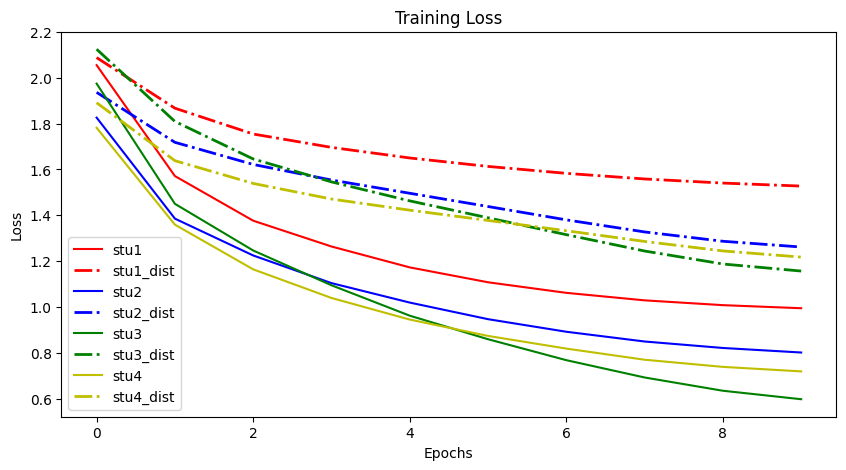

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_NDstudent1, 'r', label='stu1')
plt.plot(history_Dstudent1, 'r-.', label='stu1_dist', linewidth=2)
plt.plot(history_NDstudent2, 'b', label='stu2')
plt.plot(history_Dstudent2, 'b-.', label='stu2_dist', linewidth=2)
plt.plot(history_NDstudent3, 'g', label='stu3')
plt.plot(history_Dstudent3, 'g-.', label='stu3_dist', linewidth=2)
plt.plot(history_NDstudent4, 'y', label='stu4')
plt.plot(history_Dstudent4, 'y-.', label='stu4_dist', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [44]:
print(test_NDstudent1)
print(test_NDstudent2)
print(test_NDstudent3)
print(test_Dstudent1)
print(test_Dstudent2)
print(test_Dstudent3)

63.39
67.72
70.89
69.69
72.26
75.94


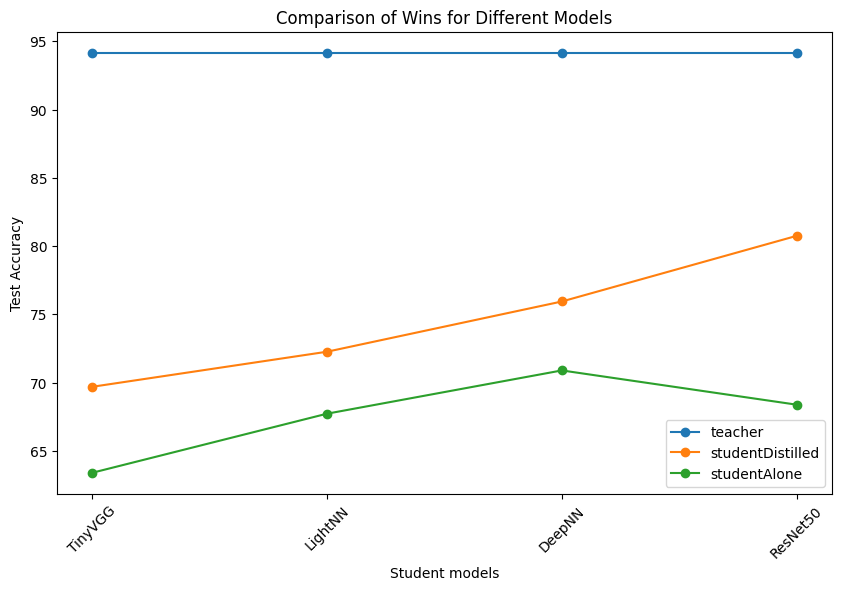

In [58]:
# Example data for distilled and non-distilled models
models = ['TinyVGG', 'LightNN', 'DeepNN', 'ResNet50']
teacher_wins = [test_teacher]*4
studentAlone_wins = [test_NDstudent1, test_NDstudent2, test_NDstudent3, test_NDstudent4]
studentDistilled_wins = [test_Dstudent1, test_Dstudent2, test_Dstudent3, test_Dstudent4]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(models, teacher_wins, marker='o', label='teacher')
plt.plot(models, studentDistilled_wins, marker='o', label='studentDistilled')
plt.plot(models, studentAlone_wins, marker='o', label='studentAlone')

# Adding labels and title
plt.xlabel('Student models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Wins for Different Models')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [122]:
lat_teacher = latency(teacher, test_loader, device)
lat_student1 = latency(Dstudent1, test_loader, device)
lat_student2 = latency(Dstudent2, test_loader, device)
lat_student3 = latency(Dstudent3, test_loader, device)
lat_student4 = latency(Dstudent4, test_loader, device)

Latency (ms) - 3761.917
Latency (ms) - 2487.097
Latency (ms) - 2388.664
Latency (ms) - 2899.445
Latency (ms) - 2984.224


In [123]:
# where radiuous represent parameters size in thousands
size_teacher = sum(p.numel() for p in teacher.parameters())*0.001
size_student1 = sum(p.numel() for p in Dstudent1.parameters())*0.001
size_student2 = sum(p.numel() for p in Dstudent2.parameters())*0.001
size_student3 = sum(p.numel() for p in Dstudent3.parameters())*0.001
size_student4 = sum(p.numel() for p in Dstudent4.parameters())*0.001

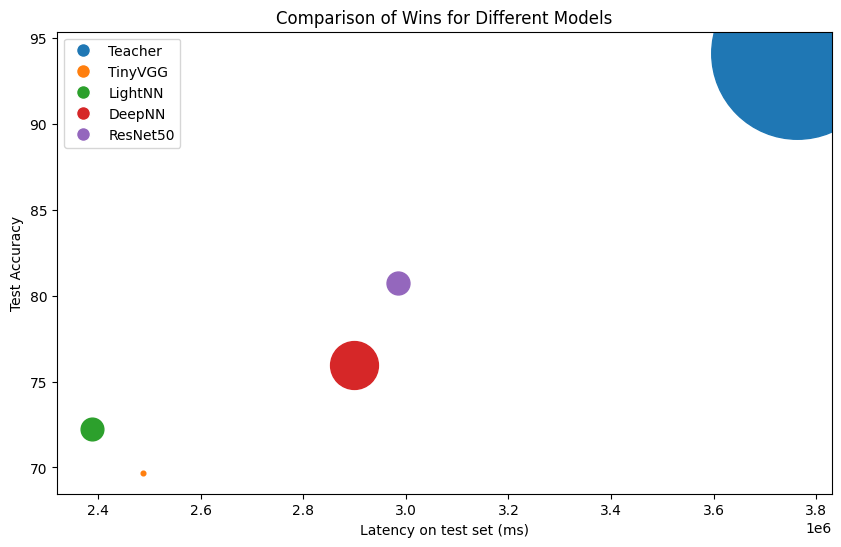

In [124]:
from matplotlib.lines import Line2D

labels = ['Teacher','TinyVGG', 'LightNN', 'DeepNN', 'ResNet50']

plt.figure(figsize=(10, 6))
plt.scatter(lat_teacher*1000, test_teacher, alpha=1, s=size_teacher)
plt.scatter(lat_student1*1000, test_Dstudent1, alpha=1, s=size_student1)
plt.scatter(lat_student2*1000, test_Dstudent2, alpha=1, s=size_student2)
plt.scatter(lat_student3*1000, test_Dstudent3, alpha=1, s=size_student3)
plt.scatter(lat_student4*1000, test_Dstudent4, alpha=1, s=size_student4)
# Adding labels and title
plt.xlabel('Latency on test set (ms)')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Wins for Different Models')

custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=10, label=labels[0]),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=10, label=labels[1]),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='C2', markersize=10, label=labels[2]),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='C3', markersize=10, label=labels[3]),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='C4', markersize=10, label=labels[4])]

plt.legend(handles=custom_legend)


# Display the plot
plt.show()